# Easy Machine Learning in Python: scikit-learn and the RandomForest algorithm.

This notebook demos the fantastically useful python machine learning package, scikit-learn.  It will particularly showcase the "Random Forest" algorithm, included in scikit-learn. (It also relies a great deal on the pandas package).

The data is from a Kaggle Contest: "The Amazon Employee Access Challenge" (https://www.kaggle.com/c/amazon-employee-access-challenge)  To run and experiment with this notebook on your own you will need to register with Kaggle and download the contest data. Just store it in the notebook's working directory.

Many thanks to Kaggle and Amazon for hosting the contest, as well as to my teammate Paul Duan, with whom I collaborated during the actual competition. 

Code for the winning solution Paul and I developed: https://github.com/bensolucky/Amazon

This Notebook's Author: Ben Solecki (bensolucky on Gmail, Kaggle and Github).

#About Scikit-Learn
Scikit-learn is a very well documented (http://scikit-learn.org/stable/) python package for machine-learning.  It allows many forms of supervised, semi-supervised and unsupervised learning, including classification, regression and clustering methods.  It also provides pre-processing, featurization and cross-validation methods. 

#About Kaggle
Kaggle (www.kaggle.com) bills itself as "the Home of Data Science", and I agree. It's the best place I've found to learn from and network with other people interested in machine learning and data science. At the heart of Kaggle are its competitions, where sponsors offer some reward for the predictive model that best solves a data problem.

Kaggle contests have a leaderboard (for example: https://www.kaggle.com/c/amazon-employee-access-challenge/leaderboard) that allow you to upload predictions and see how they score against the competition.  The leaderboard for the Amazon contest is frozen (since the contest ended), but you can still upload predictions to see how they would have done.

# About RandomForests. 
A machine learning algorithm that has emerged as one of the most popular for Kaggle competitions.

####Strengths:

* Ease and speed of use.

* Robust to "User Error" - relatively hard to make big mistakes, compared to other algorithms.

* Robust to additional noisy or extraneous features (see section 5.2 below).

* Very little Preproccessing Required (Generally convert factors / text to numerical, fill in missing values with a numerical placeholder and go!).

* Naturally picks up complex interactions between variables.

* Among the most accurate of algorithms with many types of data (especially categorical data).

* Provides some descriptive measure of variable impact, called "importances".

####Weaknesses:

* Can be less strong with strictly numerically data as well as text, binarized variables and low signal to noise ratio data.

* Need to be careful with time variables in time-series predictions, as well as with new or unseen categories of variables.

* As always: garbage-in, garbage-out.  Data quality is still a limitiation and there is no magic bullet.

# 0.0 The power of RandomForests and scikit-learn:
### These 10 lines of generic code with a runtime of under <i>1 second</i> beats the best submission of more than 600 of the 1,680 contestants. And note this contest ran for over two months.

In [1]:
# 2 lines of package importing
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# pandas makes reading csv data very easy
train = pd.read_csv('train.csv')
valid = pd.read_csv('test.csv', index_col='id') # Test data has an id column, train does not.

# Break the training data into a target ("dependent") and inputs ("inpedendents")
y = train.ACTION
X = train.drop(["ACTION"], axis=1)

# Define the model random forest's defaults and then fit it to the training data
model = RandomForestClassifier()
%time model.fit(X, y)

# Predict the fitted model on the test data and output predictions to a csv
submission = pd.DataFrame(columns=['ACTION'], index=valid.index, data=model.predict_proba(valid)[:, 1])
submission.to_csv("simple_submission.csv")

# Now submit to Kaggle - the score should almost crack the top 1000 and 0.80
# The scoring metric used is "Area Under the ROC Curve". It is bounded by 0 and 1
# For one of many online explanations try http://gim.unmc.edu/dxtests/roc3.htm

Wall time: 424 ms


# 1.0 Data Exploration.
## So how can we improve from here?  First, let's backup a bit and take a closer look at the data.

In [2]:
%pylab inline
import pandas as pd

from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
from sklearn.ensemble import RandomForestClassifier
# Some other sklearn classification algorithms to play with:
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression

from random import sample

Populating the interactive namespace from numpy and matplotlib


##How many rows and columns? Train has an extra column, because it contains our target classification variable, ACTION. ACTION is missing from the validation set, and predicting it is the whole purpose of the competition.

In [3]:
"""pandas stores data in obects called DataFrames that make it easy to manipulate the data.
If you've never used them before, think of them as sort of like excel spreadsheet objects."""
print "Train Dimensions:", train.shape[0], "rows and", train.shape[1], "columns"
print "Valid Dimensions:", valid.shape[0], "rows and", valid.shape[1], "columns"

Train Dimensions: 32769 rows and 10 columns
Valid Dimensions: 58921 rows and 9 columns


## Most of the variables are categorical and represented with meaningless numerical labels. The sole exception is our target variable, ACTION, which is binary (1s and 0s).

In [4]:
print "A peak at the first 5 rows of the training data:"
train.head()

A peak at the first 5 rows of the training data:


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Some variables have dozens of categories, others have thousands.

In [5]:
print "Count of unique values of each column in train set"
print train.apply(lambda x: len(x.unique()))
print

Count of unique values of each column in train set
ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64



# 2.0 Random Forests
### The RF algorithm builds on another method called a "Decision Tree".  RF creates many Decision Trees and injects an element of randomness into each one...a "Forest" of random trees.
Decision Trees just sequentially split the data using the input variables.  Each split is made to maximize the separation between the target variables.  So, in our example, the decision trees will try to divide the ACTION=1 rows from ACTION=0 rows as efficiently as possible.

In [6]:
# The simplest graphical representation of a RandomForest that I could find (credit: citizennet.com)
from IPython.display import Image
Image(url='https://citizennet.com/blog/wp-content/uploads/2012/11/RF.jpg') 

In [7]:
# Set a random seed so that anything random is consistent between runs
SEED = 0

# Here's the model with its defaults.
model = RandomForestClassifier(random_state = SEED)
"""Default paraemters below. Scikit learn has excellent online documentation
on these."""
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# 3 Cross-validation

## 3.1 Cross-Validation: Growing more "trees" in the forest

In [8]:
"""n_estimators is the number of trees in the random forest.  The code below iterates over the 4 
sizes provided and uses 5-fold cross-validation to give an out of sample scoring"""
num_trees = [10, 30, 50, 100]
model_grid = {'n_estimators': num_trees}

# Grid search conveniantly iterates over the parameters you'd like to cross-validate. 
grid = GridSearchCV(model, model_grid, cv=5, scoring='roc_auc')

%time grid.fit(X, y) # Runs in under a minute on my machine.

print "Here are the scores for each parameter:"
grid.grid_scores_

Wall time: 38.4 s
Here are the scores for each parameter:


[mean: 0.80250, std: 0.01744, params: {'n_estimators': 10},
 mean: 0.82963, std: 0.01373, params: {'n_estimators': 30},
 mean: 0.83792, std: 0.01325, params: {'n_estimators': 50},
 mean: 0.84881, std: 0.01035, params: {'n_estimators': 100}]

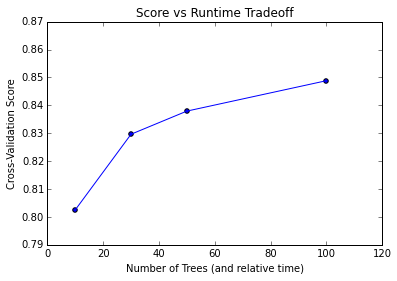

In [9]:
"""Varying trees is a trade-off between run-time and model score.  Run-time will increase 
linearly with trees. Model score will also increase up to some point, but with a 
decreasing marginal benefit."""
mean_scores = [param[1] for param in grid.grid_scores_]
scores = [param[2] for param in grid.grid_scores_]
stdv_scores = [np.std(cvs) for cvs in scores]

plt.scatter(num_trees, mean_scores)
plt.plot(num_trees, mean_scores)
plt.xlabel('Number of Trees (and relative time)')
plt.ylabel("Cross-Validation Score")
plt.title("Score vs Runtime Tradeoff")
plt.show()

## 3.2 Refit the model with more trees and submit.
###Since more trees is better, let's up the tree count to as high as our attention-spans will allow, refit and see what happens when we submit to Kaggle.

In [10]:
model.n_estimators = 1000
%time model.fit(X, y)

"""Predict the fitted model on the test data and output predictions to a csv When I submitted this 
to the leaderboard the score rose to 0.864 and we gained ~150 leaderboard spots. Not bad for 
changing one parameter. This is an easy way to improve a random forest (up to a point)."""
predictions = model.predict_proba(valid)[:, 1]
submission = pd.DataFrame(columns=['ACTION'], index=valid.index, data=predictions)
submission.to_csv("simple_submission_1000_trees.csv")

print
print "Sanity Check:"
print "Mean of ACTION in training data:", y.mean()
print "Versus Mean of predicted ACTION:", submission.ACTION.mean()
print "Difference = ", round(abs(y.mean() - submission.ACTION.mean()),3)
print "If these differ by more than 0.01 or so, something may have gone wrong."

Wall time: 43.1 s

Sanity Check:
Mean of ACTION in training data: 0.942109920962
Versus Mean of predicted ACTION: 0.93902883522
Difference =  0.003
If these differ by more than 0.01 or so, something may have gone wrong.


In [11]:
# Let's redo this as a function for reuse
def train_and_make_submission(model, test_data, train_data, csv_name):
    model.n_estimators = 1000
    
    # X and y hold the features and target, repectively.
    # or inputs / outputs, independents / dependents, whatever you want to call them
    y = train.ACTION
    X = train.drop(["ACTION"], axis=1)
    
    %time model.fit(X, y)

    # Predict the fitted model on the test data and output predictions to a csv
    predictions = model.predict_proba(test_data)[:, 1]
    submission = pd.DataFrame(columns=['ACTION'], index=test_data.index, data=predictions)
    submission.to_csv(csv_name + ".csv")

    print
    print "Sanity Check:"
    print "Mean of ACTION in training data:", y.mean()
    print "Versus Mean of predicted ACTION:", submission.ACTION.mean()
    print "Difference = ", round(abs(y.mean() - submission.ACTION.mean()),3)
    print "If these differ by more than 0.01 or so, something may have gone wrong."
    
    return model

##3.3 Cross-validation to tune the other parameters.
###scikit-learn makes it simple to find good values for those other parameters.
Sometimes a few small parameter changes can make a huge difference. FYI, if you're familiar with statistics, you can think of these parameters as just trading off bias and variance within each individual tree, by changing the way splits are made.

In [12]:
# Take it back down to 20 trees so that it runs quickly
model.n_estimators = 20

# This is a sampling of paramteres and possible values that I've previously found effective, through experimentation.  YMMV
model_grid = {'max_features':['sqrt', 0.5, None], 'max_depth': [None, 15, 5], 'min_samples_split': [4,9,25], 'min_samples_leaf':[1,3,5], 'criterion':['gini', 'entropy']}

"""RandomizedSearchCV is an effective way to search a large space of parameters for a good option.  
There are 3x3x3x3x2 = 162 combinations of the above params, and it would be tedious to search 
them all. Instead, we randomly pick 20 combinations and choose the best. It won't be as 
perfect as searching the whole space, but it will gett to a good selection much faster."""
grid = RandomizedSearchCV(model, model_grid, n_iter=20, cv=3, scoring="roc_auc")

%time grid.fit(X, y) # Runs in 47s for me

print "Best parameters found:"
print grid.best_params_

Wall time: 42.9 s
Best parameters found:
{'max_features': 0.5, 'min_samples_split': 9, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}


##Retrain and submit with the best parameters found in the last step.

In [13]:
model.set_params(**grid.best_params_)

model = train_and_make_submission(model, valid, train, "tuned_submission")

"""This model can be used to generate a sumbmissions scoring 0.87353
That's good for ~773 in the rankings (a gain of almost 100 positions)"""

Wall time: 52 s

Sanity Check:
Mean of ACTION in training data: 0.942109920962
Versus Mean of predicted ACTION: 0.940322588739
Difference =  0.002
If these differ by more than 0.01 or so, something may have gone wrong.


"This model can be used to generate a sumbmissions scoring 0.87353\nThat's good for ~773 in the rankings (a gain of almost 100 positions)"

#4 Feature Importances
Importance represents the relative % of tree splits ("decisions") that were made using each variable, across all trees in the forest.

<b>There is no guarantee that a variable that is <i>more important</i> will also make <i>better</i> decisions. </b> (Garbage in is still garbage out), but this can be used to guide decision making and further model improvements

Importances are the fraction of the time each variable is used to make a decision.
So they sum to: 1.0

The manager of the employee requesting a resource access, along with the resource itself, seem to be most important variables.
You can use these to help interpret your model, or, outside of Kaggle, to decide which variables to emphasize or de-emphasize further during your data collection and cleaning processes.


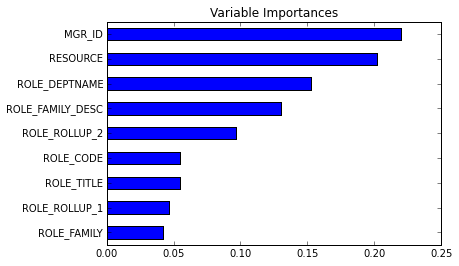

In [14]:
# Take advantage of pandas built-in plotting for a 1-liner
pd.Series(index=X.columns, data = model.feature_importances_).order().plot(kind='barh', title='Variable Importances')
print "Importances are the fraction of the time each variable is used to make a decision."
print "So they sum to:", sum(model.feature_importances_)

print
print "The manager of the employee requesting a resource access, along with the resource itself, seem to be most important variables."
print "You can use these to help interpret your model, or, outside of Kaggle, to decide which variables to emphasize or de-emphasize further during your data collection and cleaning processes."

# 5.0 Featurization (Optional)
### This section demos typical examples of adding features or cleaning data.

In [15]:
""" Concatenate train and validation together to featurize them together consistently.
This is a critical step in the featurization methodology and skipping it or performing it
incorrectly will cause huge problems """
df = pd.concat((valid, train), ignore_index=False) # ignore_index=False preserves row labeling.
# NaN (numpy code for missing), is added by pandas for the ACTION column.
print "Size of all data: ", df.shape

# A quirk of the data is that the column ROLE_CODE is completely redundant with another column.
# So it can be safely ignored.
df = df.drop(['ROLE_CODE'], axis=1)
print "New size of data: ", df.shape

Size of all data:  (91690, 10)
New size of data:  (91690, 9)


## 5.1 Add count features

In [16]:
""" For each column, we'll create a value storing the number of times each category appears 
in the data. The new data columns effectively describe how common each category is. """

print "Adding Count Features"
print "DataFrame's old dimensions:", df.shape
print 
for col in df.columns:
    if col == 'ACTION': # Of course we skip ACTION, since it's the target.
        continue
    print col,
    
    count = df[col].value_counts() # returns a series of counts for each category.
    print len(count), "unique values and the most frequent occurs", count.max(), "times."
    # Create each new count column here.
    df['count_'+col] = df[col].replace(count)
print
print "DataFrame's new dimensions:", df.shape

df.head()

Adding Count Features
DataFrame's old dimensions: (91690, 9)

MGR_ID 4913 unique values and the most frequent occurs 428 times.
RESOURCE 7518 unique values and the most frequent occurs 2828 times.
ROLE_DEPTNAME 476 unique values and the most frequent occurs 3396 times.
ROLE_FAMILY 68 unique values and the most frequent occurs 28861 times.
ROLE_FAMILY_DESC 2951 unique values and the most frequent occurs 17996 times.
ROLE_ROLLUP_1 130 unique values and the most frequent occurs 59065 times.
ROLE_ROLLUP_2 183 unique values and the most frequent occurs 12155 times.
ROLE_TITLE 361 unique values and the most frequent occurs 12082 times.

DataFrame's new dimensions: (91690, 17)


,ACTION,MGR_ID,RESOURCE,ROLE_DEPTNAME,ROLE_FAMILY,ROLE_FAMILY_DESC,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_TITLE,count_MGR_ID,count_RESOURCE,count_ROLE_DEPTNAME,count_ROLE_FAMILY,count_ROLE_FAMILY_DESC,count_ROLE_ROLLUP_1,count_ROLE_ROLLUP_2,count_ROLE_TITLE
id,,,,,,,,,,,,,,,,,
1,NaN,72734,78766,117878,19721,118177,118079,118080,117879,17,58,3396,7768,421,770,770,3838
2,NaN,4378,40644,118507,118398,122008,117961,118327,118863,58,7,787,3651,73,59065,7509,358
3,NaN,2395,75443,119488,249618,301534,117961,118300,118172,136,37,90,658,416,59065,12155,180
4,NaN,19986,43219,118403,118960,136187,117961,118225,120773,117,7,1475,1152,82,59065,6976,707
5,NaN,50015,42093,119598,118424,300136,117961,118343,118422,52,647,1592,8166,638,59065,10920,1110


In [17]:
train = df.loc[pd.notnull(df.ACTION)]
valid = df.loc[pd.isnull(df.ACTION)]
valid = valid.drop(['ACTION'], axis=1)
model = train_and_make_submission(model, valid, train, "with_counts")
"""This model can be used to generate a sumbmissions scoring 0.881
That's good for # 649 / 1684 in the rankings (another 100 positions)
and only about 0.04 from first place."""

Wall time: 1min 28s

Sanity Check:
Mean of ACTION in training data: 0.942109920962
Versus Mean of predicted ACTION: 0.94103037403
Difference =  0.001
If these differ by more than 0.01 or so, something may have gone wrong.


"This model can be used to generate a sumbmissions scoring 0.881\nThat's good for # 649 / 1684 in the rankings (another 100 positions)\nand only about 0.04 from first place."

## 5.2 Adding Noise (just for demonstration)
Let's add some extra noise columns with NO useful information.  
This will hurt the model's accuracy, but the point is to show RFs are fairly robust to noise and data quality issues.

In [18]:
# Add 5 noise columns from various random distributions
size = len(df)

df["uniform_noise"] = np.random.uniform(low=0.0, high=1.0, size=size)
df["normal_noise"] = np.random.normal(loc=0.0, scale=1.0, size=size)
df["poisson_noise"] = np.random.poisson(lam=1.0, size=size)
df["geometric_noise"] = np.random.geometric(p=0.5, size=size)
df["exponential_noise"] = np.random.exponential(scale=1.0, size=size)

print "Shape of model with extra noise:", df.shape
print "Now 5 of", df.shape[1], "columns are totally random information"
df[["uniform_noise", "normal_noise", "poisson_noise", "geometric_noise", "exponential_noise"]].describe()

Shape of model with extra noise: (91690, 22)
Now 5 of 22 columns are totally random information


,uniform_noise,normal_noise,poisson_noise,geometric_noise,exponential_noise
count,91690.000000,91690.000000,91690.000000,91690.000000,91690.000000
mean,0.500694,-0.001345,0.999127,2.004406,0.999435
std,0.288532,1.001086,1.002260,1.418257,0.996675
min,0.000005,-4.112890,0.000000,1.000000,0.000001
25%,0.251328,-0.676384,0.000000,1.000000,0.292837
50%,0.499069,-0.002718,1.000000,2.000000,0.694870
75%,0.752274,0.672247,2.000000,3.000000,1.384792
max,0.999997,4.619269,7.000000,20.000000,12.180796


In [19]:
train = df.loc[pd.notnull(df.ACTION)]
valid = df.loc[pd.isnull(df.ACTION)]
valid = valid.drop(['ACTION'], axis=1)
model = train_and_make_submission(model, valid, train, "with_noise")
"""Adding noise dropped the AUC from 0.881 to 0.863.  Noise is not helpful, but
also not disastrous to RF by any stretch."""

Wall time: 2min 26s

Sanity Check:
Mean of ACTION in training data: 0.942109920962
Versus Mean of predicted ACTION: 0.939609734043
Difference =  0.003
If these differ by more than 0.01 or so, something may have gone wrong.


'Adding noise dropped the AUC from 0.881 to 0.863.  Noise is not helpful, but\nalso not disastrous to RF by any stretch.'

##5.3 Adding Missing Data (Also For Fun)
Let's show what would happen if we had missing data.  RandomForest also handles this very well smoothly, there's no need to impute missing values, drop some data, or calculate the mean / median and substitute it in.  For other algorithms this step
can be a lot of work.

In [20]:
# Let's replace 5% of the data with NaN (numpy code for missing data)

# We'll replace data in all columns except ACTION.
feature_columns = [col for col in df.columns[df.columns != 'ACTION']]

# Below code just replaces a random 5% of the data for each column
for col in feature_columns:
    rindex =  np.array(sample(range(size), size / 20))
    df[col].iloc[rindex] = np.nan

# Check how many missing values are in each column.
# The missing values in ACTION are just from the valid column
print "Missing Values"
print df.isnull().sum()

print
print "Minimum Value for each column:"
print df.min()

"""Replace NaN with a placeholder value.  -99 was selected because it is far outside the range of 
possible existing values. RandomForest, unlike linear / logistic regression, SVM or KNNs, doesn't
really care how inputs are scaled, or what order categoricals are put in."""
df[feature_columns] = df[feature_columns].fillna(-99)

Missing Values
ACTION                    58921
MGR_ID                     4584
RESOURCE                   4584
ROLE_DEPTNAME              4584
ROLE_FAMILY                4584
ROLE_FAMILY_DESC           4584
ROLE_ROLLUP_1              4584
ROLE_ROLLUP_2              4584
ROLE_TITLE                 4584
count_MGR_ID               4584
count_RESOURCE             4584
count_ROLE_DEPTNAME        4584
count_ROLE_FAMILY          4584
count_ROLE_FAMILY_DESC     4584
count_ROLE_ROLLUP_1        4584
count_ROLE_ROLLUP_2        4584
count_ROLE_TITLE           4584
uniform_noise              4584
normal_noise               4584
poisson_noise              4584
geometric_noise            4584
exponential_noise          4584
dtype: int64

Minimum Value for each column:
ACTION                         0.000000
MGR_ID                        25.000000
RESOURCE                       0.000000
ROLE_DEPTNAME               4674.000000
ROLE_FAMILY                 3130.000000
ROLE_FAMILY_DESC            4673.000

C:\Users\ben\Anaconda\lib\site-packages\pandas\core\indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
train = df.loc[pd.notnull(df.ACTION)]
valid = df.loc[pd.isnull(df.ACTION)]
valid = valid.drop(['ACTION'], axis=1)
model = train_and_make_submission(model, valid, train, "with_missings")
"""Adding missings and replacing them with the simple placeholder method
only drops AUC a further ~0.01, from 0.863 to 0.854."""

Wall time: 2min 21s

Sanity Check:
Mean of ACTION in training data: 0.942109920962
Versus Mean of predicted ACTION: 0.93847110262
Difference =  0.004
If these differ by more than 0.01 or so, something may have gone wrong.


'Adding missings and replacing them with the simple placeholder method\nonly drops AUC a further ~0.01, from 0.863 to 0.854.'

#6 More  scikit-learn functionality
More useful functions that weren't neccessary for this example but could come in handy for other problems:

###6.1 Data Pre-processing

In [22]:
# Standardizing input data
# Not neccessary for RandomForest, but required for SVMs, logistic regressions and
# many other algorithms
from sklearn.preprocessing import StandardScaler
SS = StandardScaler(copy=False, with_mean=True, with_std=True)
SS.fit_transform(train)
print "Means:"
print train.mean()
print
print "Variances:"
print train.std()

Means:
ACTION                    3.535221e-16
MGR_ID                    5.113212e-17
RESOURCE                 -3.349744e-17
ROLE_DEPTNAME             1.482000e-16
ROLE_FAMILY               1.288806e-17
ROLE_FAMILY_DESC          2.784316e-16
ROLE_ROLLUP_1             1.059281e-15
ROLE_ROLLUP_2            -1.893908e-16
ROLE_TITLE                6.667785e-16
count_MGR_ID              2.149535e-16
count_RESOURCE            1.899295e-16
count_ROLE_DEPTNAME      -1.563914e-17
count_ROLE_FAMILY        -4.145304e-16
count_ROLE_FAMILY_DESC   -1.852980e-16
count_ROLE_ROLLUP_1      -1.335208e-15
count_ROLE_ROLLUP_2      -2.443920e-16
count_ROLE_TITLE         -2.434840e-16
uniform_noise            -2.000605e-16
normal_noise             -2.831206e-17
poisson_noise             9.157341e-16
geometric_noise           1.064900e-16
exponential_noise         7.753249e-17
dtype: float64

Variances:
ACTION                    1.000015
MGR_ID                    1.000015
RESOURCE                  1.000015
ROL

In [23]:
# Binarization
# Also not neccessary or recommended for RandomForest Algorithm
# But other techniques (Logistic Regression, for example) require something like this
print len(valid["ROLE_FAMILY"].unique()), "unique values in the ROLE_FAMILY column"

# OneHotEncoder can't deal with negative values
valid["ROLE_FAMILY"] = valid["ROLE_FAMILY"].replace(-99, 0)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
encoded = enc.fit_transform(valid[["ROLE_FAMILY"]])

print "Dimensions of Binarized ROLE_FAMILY:", encoded.shape[0], "rows and", encoded.shape[1], "columns"

69 unique values in the ROLE_FAMILY column
Dimensions of Binarized ROLE_FAMILY: 58921 rows and 69 columns


###6.2 Dimensionality Reduction

In [24]:
# PCA
# This doesn't really make sense to perform because the numbers in the data represent categories, not numerals.
# But I include it just to demo the functionality.

from sklearn.decomposition import PCA
#
pca = PCA(n_components=3)
valid = pca.fit_transform(valid)
pca.explained_variance_ratio_

array([ 0.45994184,  0.23909824,  0.07068647])